# "Floating point numbers"
> "Understand computer representation of real numbers"

- toc:true
- branch: master
- badges: true
- comments: true
- author: Saibaba Telukunta
- categories: [floating, point]

Background
---

Computer memory can store only discrete values, more specifically a predefined number of 0's and 1's for each data type. This also means, all the numbers on a continuous real number line cannot be be represented using predefined size for storage space and we will have to truncate/round extra digits that cannot be fit in the limited space. More specifically, this forces us to limit the range (minimum and maximum values) and density/packing (amount of numbers represented in a given interval) of representable real numbers.

**Fixed point notation**

One way we could represent real numbers is by using a fixed number of bits for the value before the decimal point and for the value after the decimal point. The problem is that we could be wasting space, and will not able to represent very small or very large numbers. For example consider 2 places for values before decimal point and 2 places for values after decimal point in a decimal number system (ignoring for now that computer actually uses binary number system and each place correspond to one bit of space). You can represent 00.01 to 99.99 nonzero values. The location of decimal point is fixed.

**Scientific notation to the rescue**

Could we optimize further? For example using scientific notation with the same number of places, we can store the exponent (in a chosen, implicitly assumed number base) and mantissa. Since we are storing exponent (as opposed to the integer part before the decimal point), we can cover a wider range of values. Also, let's allocate one bit for the sign (0 => positive number, 1 => negative number). Concretely,

$(-1)^{sign} * mantissa * {\beta}^{e}$

Here `mantissa` has a decimal point and we use $\beta$ as the base and $e$ is the exponent.

Taking above example now you can represent $0.0 * 10^{00}$ to $9.9 * 10^{99}$ (for brevity, ignoring the negative numbers, and assuming we keep one place value before the decimal point and another for the digit after the decimal point. And two digits for the exponent. A total of 4 digits). By allowing negative values for the exponent, you can store very small and large numbers. In above example, smallest nonzero number $0.1 * 10^{-49}$ to $9.9 * 10^{50}$. You could use 2's complement or come up with a biased representation convention where, for example, you subtract 49 from exponent positions to get actual exponent so that you can represent negative exponents as non-negative numbers for ease. So, 0 to 48 represent negative exponents, 49 is exponent 0 and 50 to 99 represent positive exponents. Also, notice also that depending on how many places we are using after the decimal point, we loose precision. 

To reiterate, with fixed point, you know implicitly where the decimal point is - with floating point, decimal point location is encoded and dynamic (based on the value of exponent). And, very small and large numbers can also be represented.

In both representations, if a number to be represented is not rational like $\sqrt 2$ or that do not have limited digits representation in chosen base (for example 0.1 has recurring digit pattern in binary representation), or has more digits than space allocated for `mantissa`, not all digits after the decimal point can be represented. So we have to truncate or round off leading to loss `precision`. More on this later.

Also, notice that since we are using exponent, the gap between the consecutive representable numbers on the real line won't increase linearly, but exponentially or log-linearly as the exponent increases.

**Normalization**

Unfortunately, above representation is not unique as we could represent the same number in multiple ways, for example:

$(-1)^{sign} * (mantissa * \beta) * {\beta}^{e-1}$, here ${mantissa}_{new} = {mantissa}$ * $\beta$ and $e_{new}$ = $e - 1$.

How to deal with this non-unique representations? Normalize! Notice that if we make sure that `mantissa` is within the range defined by the following relation:

$1 \le mantissa \lt \beta$

This guarantees that the representation is unique. Why $1 \ge$, you may ask. If not, again representation is not unique. For example $0.01 * 10^2 = 0.001 * 10^3$. You already saw an example on why `mantissa` has to be less than $\beta$.

So, in a normalized floating-point number, the mantissa has one non-zero digit to the left of the decimal point (another way to do this is have a non-zero first digit after the decimal point and only zero before the decimal point). The number zero has no normalized representation as it has no non-zero digit to put just to the left of the decimal point. Any floating-point number that can't be represented this way is said to be denormalized (for example the exponent becomes smaller than the smallest allowed value after normalizing).

In case where $\beta=2$, the only possible value for the digit left of decimal in mantissa is `1` (for decimal system, the digits are `1` through `9`), so it can be effectively *implicitly* assumed and leave one extra bit available to increase the precision.

Let $E_{min}$ = minimum value representable using given number of slots/bits for exponent. Likewise, for $E_{max}$. 

Let p = number of slots/digits in `mantissa` including the single digit before the decimal point.

Let x be an arbitrary real number and fl(x) its floating point representation. So, if $x = (d_0.d_1 \dots d_{p-1} d_p d_{p+1} \dots)_\beta * {\beta}^e$, then $fl(x) = (d_0.d_1 \dots d_{p-1})_\beta * {\beta}^e$. In the rest of the document, the base is not shown for brevity.

**Then, how do we represent 0?**

We can either (a) say that all zeros in `mantissa` means it is 0 - but then we cannot assume implicit digit. So this reduces the precision (b) use one of the exponent (like $E_{min}$) to indicate 0, reducing the space of available exponents by 1 and keep higher precision. This also preserves that the numerical ordering of nonnegative real numbers corresponds to the lexicographic ordering of their floating-point representations. This option also allows us to compare two numbers by just doing integer comparison of sign bit and exponent bits in integer unit of computer instead of floating point unit. Integer units are faster and cheaper to build them. In the rest of the document, this second convention is adopted as this is the same strategy used by IEEE-754 standard.

**What about bias?**

Another complication is that the exponent needs to be negative to represent very small numbers. So, it could be represented using 2's complement. But comparison will be slower. By using a biased representation, it can be made faster. You saw an example above where we subtracted 49. In the rest of the document, this biased representation convention is adopted as this is the same strategy used by IEEE-754 standard.

**Subnormal numbers**

So, if we represent 0 with all zeros in `exponent`, we have a decision about the values in `mantissa`? We can say (1) all zeros in `mantissa` means the we are representing 0 (2) non zero `mantissa` means, it is denormalized number (do not assume *implicit* 1 in case of binary). This second option is useful. Why?

The gap between 0 and the smallest normalized number is ($\beta^{E_{min}+1}$)  greater than the gap between smallest normalized number and the next bigger floating point number ($\beta^{E_{min}+1-p+1}$). So, in general, even though the gap is non-increasing as we go from higher numbers to lower numbers, this rule is violated between the smallest normalized number and 0. So, this requires special case handling in proofs for this range or exclude certain floating point numbers from the proofs. Also, if the result of an operation (like subtracting two very small numbers whose exponent is already minimum allowed) cannot be normalized, it would have to be flushed to zero, an abrupt change.  What can we do about this? If we allow denormalized numbers, we can assert that if the difference between $x_0$ and its nearest floating point is, say $u$, then, for any $x \le x_0$, the difference between x and its nearest floating point is at most $u$. Using this fact in proofs, we can conclude that the error produced by some sequence of computations is at most some value. Also, they help to underflow gradually. See slide 25 of http://www.cas.mcmaster.ca/~qiao/courses/cas708/slides/ch01.pdf for a picture.


**Underflow and overflow**

Given that we are using a fixed number of bits/places for exponent, you have a $E_{min}$ and a $E_{max}$ value that exponent can take. Underflow is the situation where numbers whose exponent is below the $E_{min}+1$ (remember, $E_{min}$ is already used to represent 0) exponent and hence cannot be represented (mostly as a result of an operation like subtracting two close numbers). Overflow is about the numbers whose exponent is above the $E_{max}-1$ (remember, $E_{max}$ is already used for $+-\infty$) exponent value and hence cannot be represented as well. Note that each kind of numbers can be positive or negative depending on the sign bit/place.

Subnormal numbers can help with gradual underflow. Consider for example, $x = 1.10 * 10^{E_{min}+1}$, and $y = 1.00 * 10^{E_{min}+1}$. Then $x-y = 0.1 * 10^{E_{min}+1} = 1.0 * 10^{E_{min}}$. The exponent is smaller than smallest representable value, hence result will be $0$. So, even though $x \ne y$, $x-y = 0$. To handle these cases, we could use denormalized/subnormal numbers to represent the underflow numbers (above will be $0.1 * 10^{E_{min}}$ i.e., do not constrain that digit before the decimal point > 1). This also means we do not assume *implicit* 1, in case of binary when exponent = ${E_{min}}$. Since there could be many zeros after the decimal point, we lose precision (we have to truncate/round the small number to fit in the bits/place of `mantissa` size). Another example $a = 3.0 * 2^{-64}$ and $a * a$ is too small to be represented in 32 bit float format (IEEE-754).

Also, notice that when we subtract two nearly equal quantities (and hence have matching digits for a great number of positions in `mantissa`), there will be significant loss of precision due to these large number of zeros in the fraction/mantissa.

**How to represent special numbers**

$\infty$, $-\infty$ ? We can have a convention that all 1's (in binary, or 9's in decimal) in exponent represent $\infty$. The content of `mantissa` in this case is 0. This is because, by convention we say that max value represented is $\beta^{E_{max}}$ and non-zero `mantissa` makes the number value greater than this (i.e., $\infty$) which is meaningless.

We still need to address another aspect: Any number, with the exception of zero, divided by zero yields respectively $\infty$ or $-\infty$. Dividing zero with zero results in the special NaN, the Not a Number value. NaN is useful to represent situations like addition of two infinite numbers. So, how do we represent these? Notice that when representing $\infty$ we assumed all 0's for `mantissa`. So, we can use any non-zero as meaning it is a NaN.

An example 
---

Now background is out of our way, let's see an example of how floating points are represented in computer to get a concrete idea.

We first pick how many bits we want to use to represent decimal numbers, say 8 bits.

First bit (MSB) can be used for sign: 0(+ve), 1(-ve)
Next 3 bits can be used for exponent.
Remaining 4 bits can be used for mantissa.

Let's use biased representation, so exponent value stored ranges from 0 to 7 (unsigned +ve number) with bias 3. So, actual values for exponent ranges from $E_{min} = -3$ to $E_{max} = 4$.

Let's also say that exponent = 000 with mantissa = 0000 is reserved for 0.

Let's say exponent = 111 mantissa = 0000 reserved for INFINITY.

This will rule out -3 and 4 from being used as exponents for normal numbers. So, actual represented range is from 1 to 6 (biased representation) or as values from -2 to 3.

So, we now have special cases:

exponent = 000 with mantissa != 0000 => subnormal numbers

exponent = 111 with mantissa != 0000 => NaN (Any number, with the exception of zero, divided by zero yields respectively ∞ or -∞. Dividing zero with zero results in the special NaN, the Not a Number value). NaN is useful to represent situations like addition of two infinites, $\frac{0}{0}$.


max +ve value:

0 110 1111


max -ve value:

1 110 1111

Smallest +ve number that can be represented:

0 000 0001 (subnormal, note that mantissa cannot be 0000 as then it becomes 0).

Smallest -ve number:

1 000 0001 (subnormal)


Smallest normal +ve number:

0 001 0000

Smallest normal -ve number:

1 001 0000

Gap between 0 and smallest normal +ve number = $2^{1-3} = 0.25$.
Gap between the smallest normal +ve number and the number next = <0 001 0001> - $2^{1-3}$ = $1.0001 x 2^{1-3} - 1.0000 x 2^{1-3} = 0.0001 x 2^{1-3} = 2^{1-3-4} = 0.015625$.

So, we notice that floating point representation is discrete (unlike real line), not equally spaced throughout, and finite.

Measuring rounding errors
---

Note that we are representing a real number using a fixed width storage (sign+mantissa+exponent) and hence we have a rounding error. This is measured using ULP standing for units in the last place. For a real number x, when represented using a floating point number, say, fl(x), with exponent e, a least possible change in the mantissa modifies the represented value fl(x) by ${\beta}^e * {\beta}^{-p+1} = {\beta}^{e-p+1}$. This is characterized as 1 ULP. So, all floating point numbers with the same exponent, $e$ have the same ULP. So, in a given representation (given radix, precision, base), 1 ULP is different for each value of the exponent and not constant throughout the representable range.

How do we round? there are four types of rounding we can do. Here they are with some examples (where we assume to keep 5 digits after decimal point):

* Round to nearest number representable: e.g. -0.001497 becomes -0.00150.
* Round to zero/truncate: e.g. -0.001498 becomes -0.00149.
* Round to +infinity (round up): e.g. -0.001498 becomes -0.00149.
* Round to –infinity (round down): e.g. -0.001498 becomes -0.00150.


How can we ensure the rounding is done correctly? particularly given that we cannot store digits after the lowest possible slot/digit? Use an extra digit(s) called guard digit(s). Then calculations are performed at slightly greater precision, and then stored in standard IEEE floating-point numbers after normalizing and rounding as above. Usually three extra bits are enough to ensure correctness.

ULP is good for measuring rounding error. Relative error is good for measuring rounding error due to various formula (add/subtract etc).
    
Rounding to the nearest floating-point number corresponds to an error of less than or equal to 0.5 ULP. However, when analyzing the rounding error caused by various formulas, relative error is a better measure as it is not affected by exponent.

Some proofs
---

**Rounding error introduced by nearest rounding**

$\beta = radix$ as above.

let $m = \beta - 1$

let $h = \frac{\beta}{2}$

Then, $0.h = \frac{\beta}{2} {\beta}^{-1} = \frac{1}{2}$

$x = d_0.d_1 \dots d_{p-1} d_p d_{p+1} \dots {\beta}^e$

say $d_p \lt h$, then we just truncate

$fl(x) = d_0.d_1 \dots d_{p-1} {\beta}^e$


$x - fl(x) = 0. \dots d_{p} d_{p+1}  \dots {\beta}^e$

$x - fl(x) = 0.d_{p} d_{p+1} \dots {\beta}^{-p+1} {\beta}^e$


$x - fl(x) \le 0.h m m m \dots {\beta}^{-p+1} {\beta}^e$

$x - fl(x) \le 0.h {\beta}^{-p+1} {\beta}^e$

$x - fl(x) \le \frac{1}{2} {\beta}^{-p+1+e}$

Let $d_p \ge h$, then we add $ \frac{\beta}{2} \beta^{e-p} = \frac{1}{2} \beta^{e-p+1}$ and truncate.

$fl(x) = d_0.d_1 \dots d_{p-1} \beta^e + \frac{1}{2} \beta^{e-p+1}$

$x - fl(x) = 0.0 \dots d_{p} d_{p+1}  \dots {\beta}^e -  \frac{1}{2} \beta^{e-p+1}$


$x - fl(x) = 0.d_{p} d_{p+1}  \dots {\beta}^{e-p+1} -  \frac{1}{2} \beta^{e-p+1}$

$x - fl(x) \le 0.m m  \dots {\beta}^{e-p+1} -  \frac{1}{2} \beta^{e-p+1}$


$x - fl(x) \lt 1.0 {\beta}^{e-p+1} -  \frac{1}{2} \beta^{e-p+1}$

$x - fl(x) \lt \frac{1}{2} {\beta}^{-p+1+e}$

Also, ${\beta}^{-p+1+e}$ = ulp(x), so rounding to nearest floating point keeps absolute error within half-ulp.


Consider relative error,

$\frac{|x-fl(x)|}{|fl(x)|} \lt \frac{\frac{1}{2} {\beta}^{-p+1+e}}{\beta^e} = \frac{1}{2} \beta^{-p+1}$

(here note that  $|fl(x)| ≥ 1.0 × \beta^e$}

Relative error is indpendent of exponent, hence the same for all numbers.


**Rounding error introduced by pure truncation is twice as much. Why?**


$fl(x) = d_0.d_1 \dots d_{p-1} {\beta}^e$

$x - fl(x) = 0. \dots d_{p} d_{p+1}  \dots {\beta}^e$

$x - fl(x) \le 0.m m  \dots {\beta}^{e-p+1}$

$x - fl(x) \lt 1.0  \dots {\beta}^{e-p+1}$


Operations (subtraction etc.,) using fixed bits in hardware lead to high rounding errors (the ulp between actual result vs. computed is high). Using a guard digit helps. But there is also problem of cancellation. And sometimes exact rounding (i.e,, assume infinite precision bits while operating, and round the result afterwards) is needed.


Arithmetic exceptions
---

Overflow condition: ±$\infty$, f = $1111 \dots$

Underflow condition: flush to 0, ±$2^{-bias}$, [denormalized]

Divide by zero: ±$\infty$

Invalid numbers: NaN

Inexact value due to rounding/truncation: arithmetic operations

Obviously inexact would occur very often and is usually ignored. So is the case with underflow. We may want to catch the remaining exceptions.

Sample code to demonstrate some of the concepts
---

In [1]:
from decimal import *
getcontext().prec = 28

# A class for creating floating points with given number of bits for exponent and precision

class MyFloat:
  def __init__(self, exp_bits, precision):
    self.exp_bits = exp_bits
    self.mantissa_bits = precision - 1 # implicit 1
    self.bias = (2**(self.exp_bits - 1)) - 1
    self.max_exp_value = (2**self.exp_bits) - 1

  def print_float(f):
    print(bin(f))

  def create(self, s, e, m):
    return (s << (self.exp_bits + self.mantissa_bits) | (e << self.mantissa_bits) | m)

  def sign(self, f):
    return f >> (self.exp_bits + self.mantissa_bits)

  def exp(self, f):
    return ((f >> self.mantissa_bits) & (2**self.exp_bits -1))

  def mantissa(self, f):
    return f & ((2**self.mantissa_bits) - 1)

  def fraction(self, f):

    fracs = []
    for i in range(0, self.mantissa_bits):
      e = 2**(self.mantissa_bits-i)
      fracs.append( (f & 1)/e )
      f = f >> 1
    
    return sum(fracs)

  def _epsilon(self):
    return -self.mantissa_bits

  def ulp(self, n):

    e = self.exp(n)
    s = self.sign(n)
    m = self.mantissa(n)

    r = self._special(e, s, m)

    if r is not None:
      return r
 
    e = e - self.bias
    return "2**" + str(self._epsilon() + e)

  def as_binary(self, f):

    # TODO: handle subnormal and special numbers

    s = 0

    if f < 0:
      s = 1
      f = -f
    
    e = 0
    while f < 1:
      f *= 2
      e -= 1
    
    while f > 2:
      f = f/2
      e += 1

    e = e + self.bias

    f -= 1 # implicit 1

    mbits = []

    
    if (f != 0):
      while True:
        
        f *= 2
        if f > 1:
          f -= 1
          mbits.append("1")
        elif f < 1:
          mbits.append("0")
        else:
          mbits.append("1")
          break
        
        if (len(mbits) == self.mantissa_bits):
          break

    txt = "{0} " + "{0:b}".format(e).zfill(self.exp_bits) + " " + "".join(mbits).zfill(self.mantissa_bits)
    return txt.format(s)

  def _special(self, e, s, m):
    if (e == self.max_exp_value) and (m == 0) and (s == 0):
      return "+Infinity"

    if (e == self.max_exp_value) and (m == 0) and (s == 1):
      return "-Infinity"

    if (e == self.max_exp_value and s == 0):
      return "NaN"
    if (e == self.max_exp_value and s == 1):
      return "-NaN"
    
    return None

  def as_decimal(self, n):
    e = self.exp(n)
    s = self.sign(n)
    m = self.mantissa(n)

    r = self._special(e, s, m)

    if r is not None:
      return r

    frac = self.fraction(m)
    if e > 0 and e < self.max_exp_value:
      # normalized numbers, add implicit 1
      frac += 1.0

    e -= self.bias

    if e == -self.bias:
      e += 1 # subnormal numbers, representable numbers which are immediately close to smallest normal number 
      # additionally, if we keep e=-3, then numbers smaller than smallest are represented causing confusion
      # in this case we also cannot use assumed b0 = 1 as that leads to duplicate numbers, for example then one with when e=-2 already

    return  Decimal((-1)**self.sign(n)) * Decimal(2**e) * Decimal(frac)

In [2]:
# Create IEEE 754 style single float and print details to test the MyFloat class above

myFloat32 = MyFloat(8, 24)

def print_details(n):
  print(bin(myFloat32.sign(n)))
  print(bin(myFloat32.exp(n)))
  print(bin(myFloat32.mantissa(n)))
  print(myFloat32.mantissa_bits)
  print(myFloat32.as_decimal(n))
  print(myFloat32.ulp(n))

#print_details(0x3E800000)
#print_details(0x3E1BA5E3) # 1.5199999511241912841796875E-1

#print_details(0x3F7F7CEE)  # 9.9800002574920654296875E-1

print_details(0x4480C000)   # 1030.000000000

print("0.25 => " + myFloat32.ulp(0x3E800000))
print("2    => " + myFloat32.ulp(0x40000000))
print("3    => " + myFloat32.ulp(0x40400000))
print("4    => " + myFloat32.ulp(0x40800000))
print("10   => " + myFloat32.ulp(0x41200000))
print("100  => " + myFloat32.ulp(0x42C80000))
print("1030 => " + myFloat32.ulp(0x4480C000))

print("1030 => " + myFloat32.ulp(0x4480C000))

#verified above are correct Ulp by testing through https://docs.oracle.com/javase/1.5.0/docs/api/java/lang/Math.html#ulp(float)

print("Bits for 0.25 =", myFloat32.as_binary(0.25))

print("Bits for  0.1 =", myFloat32.as_binary(0.1))


0b0
0b10001001
0b1100000000000000
23
1030.000000000
2**-13
0.25 => 2**-25
2    => 2**-22
3    => 2**-22
4    => 2**-21
10   => 2**-20
100  => 2**-17
1030 => 2**-13
1030 => 2**-13
Bits for 0.25 = 0 01111101 00000000000000000000000
Bits for  0.1 = 0 01111011 10011001100110011001100


Sample floating point number system
---

Create a floating point number type with 1 bit for sign, 8 bits for exponent, and 5 bits (1 implicit and 4 explicit) for mantissa


In [3]:
# Create a floating point number type with 1 bit for sign, 8 bits for exponent, and 5 bits (1 implicit and 4 explicit) for mantissa

myFloat = MyFloat(3, 5)

print("Epsilon" + str(myFloat._epsilon()))

xs = []
ys = []

for i in range(0, 256):
  xs.append(i)
  print("N =", i, "-> ", end='')
  y = myFloat.as_decimal(i)
  print(y)
  if (i > 111 and i < 128) or (i > 239 and i < 256):
    ys.append(0)
  else:
    ys.append(y)

Epsilon-4
N = 0 -> 0.00
N = 1 -> 0.015625
N = 2 -> 0.03125
N = 3 -> 0.046875
N = 4 -> 0.0625
N = 5 -> 0.078125
N = 6 -> 0.09375
N = 7 -> 0.109375
N = 8 -> 0.125
N = 9 -> 0.140625
N = 10 -> 0.15625
N = 11 -> 0.171875
N = 12 -> 0.1875
N = 13 -> 0.203125
N = 14 -> 0.21875
N = 15 -> 0.234375
N = 16 -> 0.25
N = 17 -> 0.265625
N = 18 -> 0.28125
N = 19 -> 0.296875
N = 20 -> 0.3125
N = 21 -> 0.328125
N = 22 -> 0.34375
N = 23 -> 0.359375
N = 24 -> 0.375
N = 25 -> 0.390625
N = 26 -> 0.40625
N = 27 -> 0.421875
N = 28 -> 0.4375
N = 29 -> 0.453125
N = 30 -> 0.46875
N = 31 -> 0.484375
N = 32 -> 0.5
N = 33 -> 0.53125
N = 34 -> 0.5625
N = 35 -> 0.59375
N = 36 -> 0.625
N = 37 -> 0.65625
N = 38 -> 0.6875
N = 39 -> 0.71875
N = 40 -> 0.75
N = 41 -> 0.78125
N = 42 -> 0.8125
N = 43 -> 0.84375
N = 44 -> 0.875
N = 45 -> 0.90625
N = 46 -> 0.9375
N = 47 -> 0.96875
N = 48 -> 1
N = 49 -> 1.0625
N = 50 -> 1.125
N = 51 -> 1.1875
N = 52 -> 1.25
N = 53 -> 1.3125
N = 54 -> 1.375
N = 55 -> 1.4375
N = 56 -> 1.5
N = 57 -

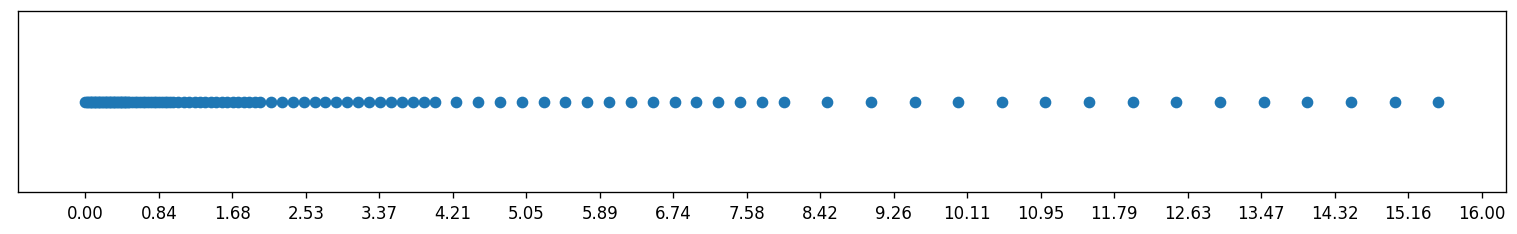

In [4]:
# Density plot of the representable numbers for above example

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure

figure(figsize=(16, 2), dpi=120)

values = ys[0:112] 

plt.scatter(values, np.zeros_like(values), cmap="hot_r", vmin=-2)
plt.xticks(np.linspace(0, 16, 20))
plt.yticks([])
plt.show()

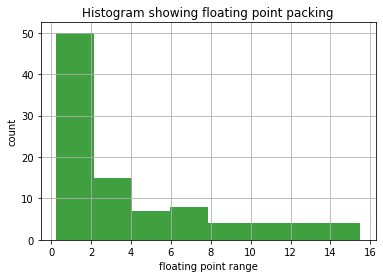

In [5]:
# density histogram of floating point numbers for above example
import numpy as np
import matplotlib.pyplot as plt

lys = []

for i in range(16, 112):
  ly = myFloat.as_decimal(i)
  lys.append(ly)

plt.hist(lys, 'auto', facecolor='g', alpha=0.75)
plt.xlabel('floating point range')
plt.ylabel('count')
plt.title('Histogram showing floating point packing')
plt.grid(True)
plt.show()

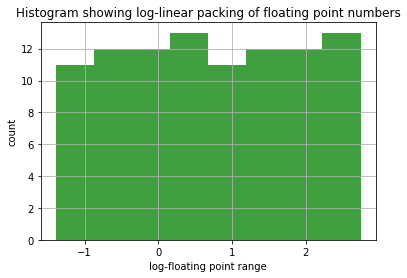

In [6]:
# density histogram of log of floating point numbers for above example

import numpy as np
import matplotlib.pyplot as plt

plt.hist([np.log(float(x)) for x in lys], 'auto', facecolor='g', alpha=0.75)

plt.xlabel('log-floating point range')
plt.ylabel('count')
plt.title('Histogram showing log-linear packing of floating point numbers')
plt.grid(True)
plt.show()

Exercises
---

* Understand half precision float vs bfloat16 representation
* Demonstrate how the knowledge of floating point representation is useful:
  * Convert from float to bfloat16.
    * Execute an example arithmetic expression using both half-float and bfloat16 and see the difference in results and explain.
  * Fast square root by halving exponent directly
* Machine epsilon: when two successive iterates differ by less than $|\epsilon|$, we may assume that the iteration has converged and stop the process. Provide a demonstration of this.

References
---

* https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html
* https://www.exploringbinary.com/the-spacing-of-binary-floating-point-numbers/
* https://softwareengineering.stackexchange.com/questions/215065/can-anyone-explain-representation-of-float-in-memory
* https://stackoverflow.com/questions/55253233/convert-fp32-to-bfloat16-in-c/55254307#55254307
* https://software.intel.com/content/www/us/en/develop/articles/intel-deep-learning-boost-new-instruction-bfloat16.html
* http://www.binaryconvert.com/result_float.html?decimal=048046049053054050053
* http://www.cs.utep.edu/interval-comp/hayes.pdf
* https://stackoverflow.com/questions/40082459/what-is-overflow-and-underflow-in-floating-point
* Floating point vs. bigint: https://stackoverflow.com/a/6320218
* http://www.cs.jhu.edu/~jorgev/cs333/readings/8-Bit_Floating_Point.pdf
* https://babbage.cs.qc.cuny.edu/IEEE-754.old/Decimal.html
* https://www.youtube.com/watch?v=p8u_k2LIZyo
* https://www-ljk.imag.fr/membres/Carine.Lucas/TPScilab/JMMuller/ulp-toms.pdf
* https://matthew-brett.github.io/teaching/floating_error.html
* http://www.math.pitt.edu/~trenchea/math1070/MATH1070_2_Error_and_Computer_Arithmetic.pdf
* http://home.iitk.ac.in/~pranab/ESO208/rajesh/03-04/Errors.pdf
* https://stackoverflow.com/a/7524916
* http://www.cas.mcmaster.ca/~qiao/courses/cas708/slides/ch01.pdf
* https://stackoverflow.com/questions/43965347/ulp-unit-of-least-precision
* Algorithms for standard operations: https://www.rfwireless-world.com/Tutorials/floating-point-tutorial.html
* https://www.sciencedirect.com/topics/computer-science/fixed-point-number
* https://stackoverflow.com/questions/51170944/understanding-the-usefulness-of-denormalized-floating-point-numbers
* https://www.ias.ac.in/public/Volumes/reso/021/01/0011-0030.pdf
